# Arabic Poet Classifier: Poet Detection from Poetry

Arabic Poet Classifier that detects the poet from poetry

In [1]:
!pip install datasets
!pip install pyarabic
!pip install tashaphyne

!pip install nltk
!pip install nltk scikit-learn

!python -m nltk.downloader punkt
!pip install Arabic-Stopwords
!pip install transformers
!pip install fasttext

!pip install spacy-transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.5/251.5 kB 6.2 MB/s eta 0:00:00
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.5 MB/s eta 0:00:00
  

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
import sklearn
import string
import nltk
import sklearn
import matplotlib.pyplot as plt
import numpy as np

import spacy_transformers

import arabicstopwords.arabicstopwords as stp
from time import time
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot

from pyarabic.araby import normalize_hamza, normalize_alef
from pyarabic.araby import normalize_ligature, strip_diacritics
from arabicstopwords.arabicstopwords import stopwords_list
from tashaphyne.stemming import ArabicLightStemmer
from transformers import BertTokenizer

import fasttext
import fasttext.util


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier



/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# .1. Loading Dataset



## 1.1. Loading First Dataset

In [3]:
from datasets import load_dataset

dataset_dict = load_dataset("arbml/ashaar", download_mode="force_redownload")

print(f"Train dataset size: {len(dataset_dict['train'])}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/254630 [00:00<?, ? examples/s]

Train dataset size: 254630


In [4]:
# Ashaar Dataset as Dataframe
dataset_ashaar = pd.DataFrame(dataset_dict['train'])
dataset_ashaar.head()
dataset_ashaar.shape

(254630, 12)

from Ashaar dataset we are using four features besides the peot name as target.

Current Features:
- poem meter
- poem verses
- poem theme
- poet era

Target:
- poet name

## 1.2. Create Project dataset

In [5]:
dataset_project = dataset_ashaar.drop(['poem title', 'poem url', 'poet description', 'poet url', 'poet location', 'poem description', 'poem language type'], axis=1)

In [6]:
dataset_project.head()

,poem meter,poem verses,poem theme,poet name,poet era
0,بحر الخفيف,"[أَصبَحَ المُلك لِلَّذي فَطر الخَل, قَ بِتَقدي...",قصيدة دينية,الامير منجك باشا,العصر العثماني
1,بحر مجزوء الرمل,"[مِن أَي مَولى اِرتَجي, وَلاي باب التَجي, وَال...",قصيدة دينية,الامير منجك باشا,العصر العثماني
2,بحر البسيط,"[العَبد عَبدك يا مَن أَنتَ سَيدهُ, وَلَيسَ غَي...",قصيدة ذم,الامير منجك باشا,العصر العثماني
3,بحر الكامل,"[لَو كُنتَ أَطمَع بِالمَنام تَوهما, لَسالَت طَ...",قصيدة عامه,الامير منجك باشا,العصر العثماني
4,بحر الوافر,"[يعد عَليَّ أَنفاسي ذُنوباً, إِذا ما قُلت أَفد...",قصيدة عامه,الامير منجك باشا,العصر العثماني


# .2. Data Preprocessing / Processing

## 2.1. Missing Values

In [7]:
# Check for missing values in the DataFrame
missing_values = dataset_project.isnull().sum()

# Print the missing values
print("Missing values in the DataFrame:")
print(missing_values)
print('---------------------------------------------')

Missing values in the DataFrame:
poem meter     101277
poem verses         0
poem theme     187110
poet name           0
poet era       107209
dtype: int64
---------------------------------------------


In [8]:
# Remove rows with any missing values
dataset_project = dataset_project.dropna()

# Check if any missing values remain
missing_values = dataset_project.isnull().sum()
print("Missing values in the DataFrame after removing rows with missing values:")
print(missing_values)

len(dataset_project)

Missing values in the DataFrame after removing rows with missing values:
poem meter     0
poem verses    0
poem theme     0
poet name      0
poet era       0
dtype: int64


54701

In [9]:
# Separate features and target
features = dataset_project.drop('poet name', axis=1)
target = dataset_project['poet name']

## 2.2. Normalization

- Strip Deiacritics (Done)
- Strip Elongation (Done)
- Normalize Hamza
- Normalize Alef
- Normalize Yah

In [10]:
# Function to preprocess text

def preprocess_text(row):

  # text = row['poem verses']
  # text = text.join(text)

  # Combine text columns into a single string
  text = " ".join([str(row['poem meter']), str(row['poem verses']), str(row['poem theme']), str(row['poet era'])])

  # Clean and normalize the text
  text = text.strip()  # Remove extra spaces
  text = normalize_hamza(text)  # Normalize Hamza
  text = normalize_alef(text)   # Normalize Alef
  text = normalize_ligature(text)  # Normalize Ligature
  text = strip_diacritics(text).replace("ى", "ي") # Normalize Yah
  text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation


  return text

features['Normalized Poem'] = features.apply(lambda row: preprocess_text(row), axis=1)

In [11]:
features.head()

,poem meter,poem verses,poem theme,poet era,Normalized Poem
0,بحر الخفيف,"[أَصبَحَ المُلك لِلَّذي فَطر الخَل, قَ بِتَقدي...",قصيدة دينية,العصر العثماني,بحر الخفيف ءصبح الملك للذي فطر الخل ق بتقدير ل...
1,بحر مجزوء الرمل,"[مِن أَي مَولى اِرتَجي, وَلاي باب التَجي, وَال...",قصيدة دينية,العصر العثماني,بحر مجزوء الرمل من ءي مولا ارتجي ولاي باب التج...
2,بحر البسيط,"[العَبد عَبدك يا مَن أَنتَ سَيدهُ, وَلَيسَ غَي...",قصيدة ذم,العصر العثماني,بحر البسيط العبد عبدك يا من ءنت سيده وليس غيرك...
3,بحر الكامل,"[لَو كُنتَ أَطمَع بِالمَنام تَوهما, لَسالَت طَ...",قصيدة عامه,العصر العثماني,بحر الكامل لو كنت ءطمع بالمنام توهما لسالت طيف...
4,بحر الوافر,"[يعد عَليَّ أَنفاسي ذُنوباً, إِذا ما قُلت أَفد...",قصيدة عامه,العصر العثماني,بحر الوافر يعد علي ءنفاسي ذنوبا ءذا ما قلت ءفد...


## 2.3. Tokenization


In [12]:
# Function to tokenize text
def tokenize_text(text):
    return word_tokenize(text)

features['Tokens'] = features['Normalized Poem'].apply(tokenize_text)

In [13]:

features.head()

,poem meter,poem verses,poem theme,poet era,Normalized Poem,Tokens
0,بحر الخفيف,"[أَصبَحَ المُلك لِلَّذي فَطر الخَل, قَ بِتَقدي...",قصيدة دينية,العصر العثماني,بحر الخفيف ءصبح الملك للذي فطر الخل ق بتقدير ل...,"[بحر, الخفيف, ءصبح, الملك, للذي, فطر, الخل, ق,..."
1,بحر مجزوء الرمل,"[مِن أَي مَولى اِرتَجي, وَلاي باب التَجي, وَال...",قصيدة دينية,العصر العثماني,بحر مجزوء الرمل من ءي مولا ارتجي ولاي باب التج...,"[بحر, مجزوء, الرمل, من, ءي, مولا, ارتجي, ولاي,..."
2,بحر البسيط,"[العَبد عَبدك يا مَن أَنتَ سَيدهُ, وَلَيسَ غَي...",قصيدة ذم,العصر العثماني,بحر البسيط العبد عبدك يا من ءنت سيده وليس غيرك...,"[بحر, البسيط, العبد, عبدك, يا, من, ءنت, سيده, ..."
3,بحر الكامل,"[لَو كُنتَ أَطمَع بِالمَنام تَوهما, لَسالَت طَ...",قصيدة عامه,العصر العثماني,بحر الكامل لو كنت ءطمع بالمنام توهما لسالت طيف...,"[بحر, الكامل, لو, كنت, ءطمع, بالمنام, توهما, ل..."
4,بحر الوافر,"[يعد عَليَّ أَنفاسي ذُنوباً, إِذا ما قُلت أَفد...",قصيدة عامه,العصر العثماني,بحر الوافر يعد علي ءنفاسي ذنوبا ءذا ما قلت ءفد...,"[بحر, الوافر, يعد, علي, ءنفاسي, ذنوبا, ءذا, ما..."


## 2.4. Stop Word Removal

In [14]:
import nltk
nltk.download('stopwords')

# Function to remove stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('arabic'))
    return [token for token in tokens if token not in stop_words]

features['Filtered Tokens'] = features['Tokens'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
features.head()

,poem meter,poem verses,poem theme,poet era,Normalized Poem,Tokens,Filtered Tokens
0,بحر الخفيف,"[أَصبَحَ المُلك لِلَّذي فَطر الخَل, قَ بِتَقدي...",قصيدة دينية,العصر العثماني,بحر الخفيف ءصبح الملك للذي فطر الخل ق بتقدير ل...,"[بحر, الخفيف, ءصبح, الملك, للذي, فطر, الخل, ق,...","[بحر, الخفيف, ءصبح, الملك, للذي, فطر, الخل, بت..."
1,بحر مجزوء الرمل,"[مِن أَي مَولى اِرتَجي, وَلاي باب التَجي, وَال...",قصيدة دينية,العصر العثماني,بحر مجزوء الرمل من ءي مولا ارتجي ولاي باب التج...,"[بحر, مجزوء, الرمل, من, ءي, مولا, ارتجي, ولاي,...","[بحر, مجزوء, الرمل, ءي, مولا, ارتجي, ولاي, باب..."
2,بحر البسيط,"[العَبد عَبدك يا مَن أَنتَ سَيدهُ, وَلَيسَ غَي...",قصيدة ذم,العصر العثماني,بحر البسيط العبد عبدك يا من ءنت سيده وليس غيرك...,"[بحر, البسيط, العبد, عبدك, يا, من, ءنت, سيده, ...","[بحر, البسيط, العبد, عبدك, ءنت, سيده, وليس, غي..."
3,بحر الكامل,"[لَو كُنتَ أَطمَع بِالمَنام تَوهما, لَسالَت طَ...",قصيدة عامه,العصر العثماني,بحر الكامل لو كنت ءطمع بالمنام توهما لسالت طيف...,"[بحر, الكامل, لو, كنت, ءطمع, بالمنام, توهما, ل...","[بحر, الكامل, كنت, ءطمع, بالمنام, توهما, لسالت..."
4,بحر الوافر,"[يعد عَليَّ أَنفاسي ذُنوباً, إِذا ما قُلت أَفد...",قصيدة عامه,العصر العثماني,بحر الوافر يعد علي ءنفاسي ذنوبا ءذا ما قلت ءفد...,"[بحر, الوافر, يعد, علي, ءنفاسي, ذنوبا, ءذا, ما...","[بحر, الوافر, يعد, علي, ءنفاسي, ذنوبا, ءذا, قل..."


## 2.5. Stemming

In [16]:
# Initialize the stemmer
stemmer = ArabicLightStemmer()

In [ ]:
# Function to stem tokens
def stem_tokens(tokens):
  return [stemmer.light_stem(token) for token in tokens]

features['Stemmed Tokens'] = features['Filtered Tokens'].apply(stem_tokens)
features['Stemmed Poem Text'] = features['Stemmed Tokens'].apply(lambda x: ' '.join(x))


# Print a sample of preprocessed data
print("Sample preprocessed data:")
print(features['Stemmed Poem Text'].head())

In [ ]:
features.head()

In [ ]:
# Encoding Categorical Features

categorical_columns = ['poem meter', 'poem theme', 'poet era']

print("Categorical Features:", categorical_columns)

# Encoding categorical features
for col in categorical_columns:

  le = LabelEncoder()

  values = list(features[col].values)

  le.fit(values)

  features['encode ' + col] = le.transform(values)

features.head()

In [ ]:
print(f'{features.shape=}')
print(f'{target.shape=}')

print(f'{dataset_project.shape=}')

In [ ]:
# Encoding Target
le = LabelEncoder()
target_encoding = le.fit_transform(target)

In [ ]:
len(np.unique(target_encoding))

# .3. Features Extraction

- 1. Character Features
- 2. Lexical Features
- 3. Specific Words Per Aurthors
- 4. Syntatic Features
- 5. Poetry Features
- 6. Structural Features
- 7. Semantic Features

- Classification Features:
    - Word-level features: word frequencies, n-grams, word embeddings.
    - Poetic features: rhyme patterns, meter, poetic devices.
    - Structural features: stanza length, line length.

## 3.1. Character Features

In [ ]:
# Function to extract character n-grams
def extract_char_ngrams(texts, n):
  vectorizer = CountVectorizer(analyzer='char', ngram_range=(n, n))
  ngram_counts = vectorizer.fit_transform(texts)
  return vectorizer, ngram_counts


# Function to select top features using Chi-Squared test
def select_top_features_chi2(X, y, k=500):
  chi2_selector = SelectKBest(chi2, k=k)
  X_kbest = chi2_selector.fit_transform(X, y)
  return chi2_selector, X_kbest


# Function to select top features using Information Gain
def select_top_features_ig(X, y, k=500):
  ig_scores = mutual_info_classif(X, y)
  top_indices = ig_scores.argsort()[-k:][::-1]
  return top_indices


# Function to perform PCA
def perform_pca(X, n_components=1):
  pca = TruncatedSVD(n_components=n_components)
  X_pca = pca.fit_transform(X)
  return pca, X_pca

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

# Print the shapes of the training and testing sets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Train

In [ ]:
# Dictionary to store the extracted character n-grams
char_ngrams_features = {}

# Extracting character 3-grams
n = 3
vectorizer, ngram_counts = extract_char_ngrams(X_train['Stemmed Poem Text'], n)
char_ngrams_features[n] = {
  'feature_names': vectorizer.get_feature_names_out(),
  'counts': ngram_counts.toarray()
}


# Perform Chi-Squared feature selection
chi2_selector, X_chi2_selected = select_top_features_chi2(ngram_counts, y_train, k=500)

# Perform Information Gain feature selection
ig_top_indices = select_top_features_ig(ngram_counts, y_train, k=500)

# Get selected feature names
selected_feature_names_chi2 = vectorizer.get_feature_names_out()[chi2_selector.get_support()]
selected_feature_names_ig = vectorizer.get_feature_names_out()[ig_top_indices]


# Perform PCA on the selected features from Chi-Squared
pca_chi2, X_pca_chi2 = perform_pca(X_chi2_selected, n_components=1)  # Provide an integer value


# Perform Information Gain feature selection
ig_top_indices = select_top_features_ig(ngram_counts, y_train, k=500)

# Extract selected features for Information Gain
X_ig_selected = ngram_counts[:, ig_top_indices]

# Perform PCA on the selected features from Information Gain
pca_ig, X_pca_ig = perform_pca(X_ig_selected, n_components=1)  # Provide an integer value


# Store selected features and PCA results in the dictionary
char_ngrams_features[n]['selected_features_chi2'] = {
  'feature_names': selected_feature_names_chi2,
  'counts': X_chi2_selected.toarray(),
  'pca_counts': X_pca_chi2
}
char_ngrams_features[n]['selected_features_ig'] = {
  'feature_names': selected_feature_names_ig,
  'counts': X_ig_selected.toarray(),
  'pca_counts': X_pca_ig
}


In [ ]:
# Print the results
print("Selected features using Chi-Squared:")
print(char_ngrams_features[n]['selected_features_chi2']['feature_names'])
print("PCA transformed data shape (Chi-Squared):", X_pca_chi2.shape)
print("Values of the first 20 lines of X_pca_chi2:")
print(X_pca_chi2[:20])


In [ ]:
print("\nSelected features using Information Gain:")
print(char_ngrams_features[n]['selected_features_ig']['feature_names'])
print("PCA transformed data shape (Information Gain):", X_pca_ig.shape)

print("Values of the first 20 lines of X_pca_chi2:")
print(X_pca_ig[:20])

In [ ]:
# Create a DataFrame for X_pca_ig and X_pca_chi2
# Change the column names accordingly
df_pca_ig = pd.DataFrame(X_pca_ig, columns=['X_pca_ig'])
df_pca_chi2 = pd.DataFrame(X_pca_chi2, columns=['X_pca_chi2'])

# Reset the index of X_train["Stemmed Poem Text"]
X_train_reset_index = X_train["Stemmed Poem Text"].reset_index(drop=True)

# Concatenate X_train_reset_index with the PCA transformed data
X_train_char = pd.concat([X_train_reset_index, df_pca_ig, df_pca_chi2], axis=1)

# Display the new DataFrame
X_train_char.head()


Test

In [ ]:
# Dictionary to store the extracted character n-grams
char_ngrams_features_test = {}

# Extracting character 3-grams for test data
n = 3
vectorizer_test, ngram_counts_test = extract_char_ngrams(X_test['Stemmed Poem Text'], n)
char_ngrams_features_test[n] = {
    'feature_names': vectorizer_test.get_feature_names_out(),
    'counts': ngram_counts_test.toarray()
}

# Perform Chi-Squared feature selection for test data
chi2_selector_test, X_chi2_selected_test = select_top_features_chi2(ngram_counts_test, y_test, k=500)

# Perform Information Gain feature selection for test data
ig_top_indices_test = select_top_features_ig(ngram_counts_test, y_test, k=500)

# Get selected feature names for test data
selected_feature_names_chi2_test = vectorizer_test.get_feature_names_out()[chi2_selector_test.get_support()]
selected_feature_names_ig_test = vectorizer_test.get_feature_names_out()[ig_top_indices_test]

# Perform PCA on the selected features from Chi-Squared for test data
pca_chi2_test, X_pca_chi2_test = perform_pca(X_chi2_selected_test, n_components=1)  # Provide an integer value

# Extract selected features for Information Gain for test data
X_ig_selected_test = ngram_counts_test[:, ig_top_indices_test]

# Perform PCA on the selected features from Information Gain for test data
pca_ig_test, X_pca_ig_test = perform_pca(X_ig_selected_test, n_components=1)  # Provide an integer value


# Store selected features and PCA results in the dictionary for test data
char_ngrams_features_test[n]['selected_features_chi2'] = {
  'feature_names': selected_feature_names_chi2_test,
  'counts': X_chi2_selected_test.toarray(),
  'pca_counts': X_pca_chi2_test
}
char_ngrams_features_test[n]['selected_features_ig'] = {
  'feature_names': selected_feature_names_ig_test,
  'counts': X_ig_selected_test.toarray(),
  'pca_counts': X_pca_ig_test
}

In [ ]:
# Print the results for test data
print("Selected features using Chi-Squared for test data:")
print(char_ngrams_features_test[n]['selected_features_chi2']['feature_names'])
print("PCA transformed data shape (Chi-Squared) for test data:", X_pca_chi2_test.shape)
print("Values of the first 20 lines of X_pca_chi2 for test data:")
print(X_pca_chi2_test[:20])

In [ ]:
print("\nSelected features using Information Gain for test data:")
print(char_ngrams_features_test[n]['selected_features_ig']['feature_names'])
print("PCA transformed data shape (Information Gain) for test data:", X_pca_ig_test.shape)

print("Values of the first 20 lines of X_pca_chi2 for test data:")
print(X_pca_ig_test[:20])

In [ ]:
# Create a DataFrame for X_pca_ig and X_pca_chi2 for test data
# Change the column names accordingly
df_pca_ig_test = pd.DataFrame(X_pca_ig_test, columns=['X_pca_ig_test'])
df_pca_chi2_test = pd.DataFrame(X_pca_chi2_test, columns=['X_pca_chi2_test'])

# Reset the index of X_test["Stemmed Poem Text"]
X_test_reset_index = X_test["Stemmed Poem Text"].reset_index(drop=True)

# Concatenate X_test_reset_index with the PCA transformed data for test data
X_test_char = pd.concat([X_test_reset_index, df_pca_ig_test, df_pca_chi2_test], axis=1)

# Display the new DataFrame for test data
X_test_char.head()

## 3.2. TF-IDF (Term Frequency-Inverse Document Frequency)

In [ ]:
# Transform the text data into TF-IDF feature vectors
vectorizer = TfidfVectorizer()
features_tfidf = vectorizer.fit_transform(features['Normalized Poem'])

# .4. Feature Selection


Principal Componrnt Analysis (PCA)

# .4.2 Split Dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

# Print the shapes of the training and testing sets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

In [ ]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(features_tfidf, target, test_size = 0.2, random_state = 42)

# Print the shapes of the training and testing sets
print(f"Shape of X_train: {X_train_tfidf.shape}")
print(f"Shape of X_test: {X_test_tfidf.shape}")
print(f"Shape of y_train: {y_train_tfidf.shape}")
print(f"Shape of y_test: {y_test_tfidf.shape}")

In [ ]:
X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(features, target_encoding, test_size = 0.2, random_state = 42)

# Print the shapes of the training and testing sets
print(f"Shape of X_train: {X_train_en.shape}")
print(f"Shape of X_test: {X_test_en.shape}")
print(f"Shape of y_train: {y_train_en.shape}")
print(f"Shape of y_test: {y_test_en.shape}")

# .5. Model

## 5.X.1. Training Helper Functions

## 5.X.2. Evaluation Helper Functions
Evaluation metrics ccuracy, precision, recall, F1-score

1. **Evaluation Results**

The evaluation of our proposed solution involved assessing the performance of the AI models in generating Arabic poetry resembling the styles of renowned poets. The following metrics were utilized for evaluation:

- Accuracy: The overall correctness of the generated poems in capturing the essence of the poets' styles.
- Precision: The proportion of accurately generated poems resembling the style of the target poets out of all generated poems.
- Recall: The proportion of accurately generated poems resembling the style of the target poets out of all potential poems that could be generated.
- F1-Score: The harmonic mean of precision and recall, providing a balanced measure of the models' performance in capturing the poets' styles.

Through rigorous evaluation using these metrics, we were able to quantitatively assess the effectiveness of our AI models in producing Arabic poetry that mirrors the styles of specific poets.

## 5.1. Linear Support Vector Classification (LSVC)

### 5.1.1. Model Training

In [ ]:
gjcfghcff56756576567fghfhfc575765765

In [ ]:
# Define the range for the 'C' parameter
C_range = [0.01, 0.1, 1, 10, 100]  # Modify the range as needed
accuracy_lsvc = []

# Train and evaluate the Linear SVC model with different 'C' values
for C in C_range:

  # Initialize and train the Linear Support Vector Classifier (LSVC) model
  model_lsvc = LinearSVC(C = C, random_state = 42)
  model_lsvc.fit(X_train_tfidf, y_train_en)

  # Make predictions on the test set
  y_pred = model_lsvc.predict(X_test_tfidf)

  # Evaluate the model's performance | y_test_tfidf
  accuracy = accuracy_score(y_test_en, y_pred)
  accuracy_lsvc.append(accuracy)
  print(f"C: {C}, Accuracy: {accuracy:.4f}")

C: 0.01, Accuracy: 0.2856
C: 0.1, Accuracy: 0.4863
C: 1, Accuracy: 0.5759
C: 10, Accuracy: 0.5813


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C: 100, Accuracy: 0.5802


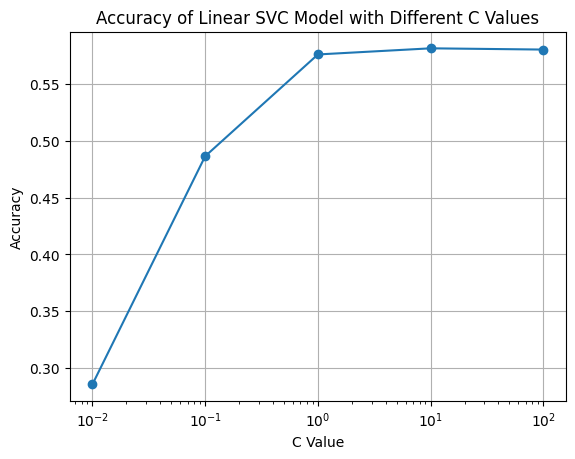

In [ ]:
# report = classification_report(y_test_tfidf, y_pred)
# print("Classification Report:\n" + report)

# Plot the accuracy values
plt.plot(C_range, accuracy_lsvc, marker='o')
plt.title('Accuracy of Linear SVC Model with Different C Values')
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.grid(True)

# Use logarithmic scale for better visualization of 'C' values
plt.xscale('log')

plt.show()

### 5.1.2. Model Evaluation

In [ ]:
# Evaluate the final model with the best 'C' value
best_C = 10
model_lsvc = LinearSVC(C = best_C, random_state = 42)
model_lsvc.fit(X_train_tfidf, y_train_en)

In [ ]:
y_pred_lsvc = model_lsvc.predict(X_test_tfidf)

test_accuracy_lsvc = accuracy_score(y_test_en, y_pred)
test_precision_lsvc = precision_score(y_test_en, y_pred)
test_recall_lsvc = recall_score(y_test_en, y_pred)
test_accuracy_lsvc = accuracy_score(y_test_en, y_pred)


print(f"Final model accuracy with C={best_C}: {test_accuracy_lsvc:.4f}")
print(f"Final model precision with C={best_C}: {test_precision_lsvc:.4f}")
print(f"Final model recall with C={best_C}: {test_recall_lsvc:.4f}")
print(f"Final model accuracy with C={best_C}: {test_accuracy_lsvc:.4f}")


report_lsvc = classification_report(y_test_en, y_pred)
print("Classification Report:\n" + report_lsvc)

## 5.2. FastText

### 5.2.1. Model Training

In [38]:
# Prepare data for FastText (FastText expects a specific format)
train_data = pd.DataFrame({'label': y_train, 'text': X_train['Stemmed Poem Text']})
test_data = pd.DataFrame({'label': y_test, 'text': X_test['Stemmed Poem Text']})

# Add the required prefix to the labels
train_data['label'] = '__label__' + train_data['label'].astype(str)
test_data['label'] = '__label__' + test_data['label'].astype(str)

# Save the data in the required format
train_data[['label', 'text']].to_csv('train_fasttext.txt', index=False, sep=' ', header=False, quoting=3, escapechar='\\')
test_data[['label', 'text']].to_csv('test_fasttext.txt', index=False, sep=' ', header=False, quoting=3, escapechar='\\')

# Train the FastText model
model_ft = fasttext.train_supervised(input='train_fasttext.txt', lr=1.0, epoch=25, wordNgrams=2)

In [39]:
# Evaluate the model
result = model_ft.test('test_fasttext.txt')
print(f"Number of examples: {result[0]}")
print(f"Precision: {result[1]}")
print(f"Recall: {result[2]}")

Number of examples: 10937
Precision: 0.9262137697723325
Recall: 0.9262137697723325


In [40]:
# Initialize lists to store epoch numbers and corresponding accuracy values
epochs = []
accuracy_ft = []
results_ft = []

# Train the FastText model and collect accuracy values for each epoch
for epoch in range(1, 20):
  # , wordNgrams = 2
  model = fasttext.train_supervised(input='train_fasttext.txt', lr = 0.1, epoch = epoch)
  result = model.test('test_fasttext.txt')
  epochs.append(epoch)
  accuracy_ft.append(result[1])
  results_ft.append(result)

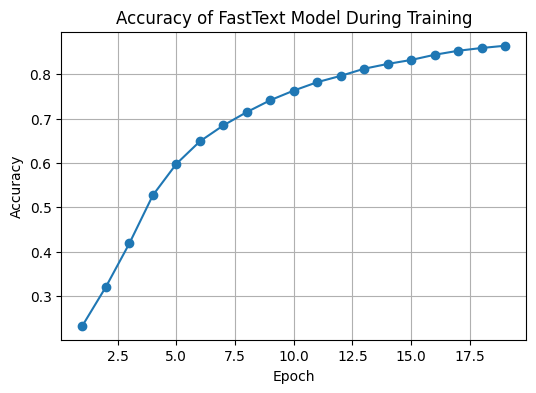

In [41]:
# Plot the accuracy values
plt.figure(figsize=(6, 4))
plt.plot(epochs, accuracy_ft, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy of FastText Model During Training')
plt.grid(True)
plt.show()

### 5.2.2. Model Evaluation

In [43]:
# Evaluate the model on the test set
text_result_ft = model_ft.test('test_fasttext.txt')

# Calculate F1-score
precision_ft = result[1]
recall_ft = result[2]
f1_score_ft = 2 * (precision_ft * recall_ft) / (precision_ft + recall_ft)

# Print the results
print(f"Number of samples: {text_result_ft[0]}")
print(f"Precision: {precision_ft}")
print(f"Recall: {recall_ft}")
print(f"F1-score: {f1_score_ft}")

Number of samples: 10937
Precision: 0.8644052299533693
Recall: 0.8644052299533693
F1-score: 0.8644052299533693


## 5.3. Random Forest Classifier

### 5.3.1. Model Training

In [ ]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train_tfidf, y_train_en)

In [ ]:
# Make predictions on the test data
y_pred_rf = rf_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy_rf = accuracy_score(y_test_en, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.4f}")

report_rf = classification_report(y_test_en, y_pred)
print("Classification Report:\n" + report_rf)

### 5.3.2. Model Evaluation

## 5.4. Logistic Regression

### 5.4.1. Model Training

In [ ]:
# Initialize the Logistic Regression model
model = LogisticRegression()

# Fit the model on the training data
model.fit(X_train_tfidf, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test_tfidf)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy * 100}%")

### 5.4.2. Model Evaluation

# .6. Final Result

## 6.1. Models Results Comparison

### 6.1.1. SVM Results

### 6.1.2. FastText

### 6.1.3. Random Forest

## 6.2. Best Peforming model

The model FastText gives the best results with Precision of 92.62%

## 6.3. Extra


1.2. Loading Second Dataset

1.3. Loading Third Dataset

Multi-Classifier

## 6.4. Resources

### 6.4.1. Datasets
- [Ashaar Dataset](https://huggingface.co/datasets/arbml/ashaar)
- [Arabic Poetry](https://www.kaggle.com/datasets/ahmedabelal/arabic-poetry)
- [Arabic Poetry Dataset (6th - 21st century)
](https://www.kaggle.com/datasets/fahd09/arabic-poetry-dataset-478-2017/data)


#### Draft

In [ ]:
Stope here

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp('السلام عليكم ورحمة الله وبركاته')
embeddings = [token.vector for token in doc]
print('Word embeddings:', embeddings)



import spacy
nlp = spacy.blank("ar") # empty English pipeline

# create the config with the name of the model
# values omitted will get default values
config = {
    "model": {
        "@architectures": "spacy-transformers.TransformerModel.v3",
        "name": "aubmindlab/bert-large-arabertv02"
    }
}
nlp.add_pipe("transformer", config = config)
nlp.initialize()
doc = nlp("فريك الذرة لذيذة")
print(doc._.trf_data) # all the Transformer output is stored here


# Transform the text data into TF-IDF feature vectors

import spacy
nlp = spacy.load('en_core_web_sm')


doc_train = nlp(X_train['Normalized Poem'])
embeddings_train = [token.vector for token in doc]

print('Word embeddings:', embeddings_train)


Latent Dirichlet allocation (LDA)

In [ ]:
# Initialize and train the LDA model
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
X_train_lda = lda_model.fit_transform(X_train_tfidf)

# Split the data into training and testing sets
X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X_train_lda, y_train, test_size=0.2, random_state=42)

# Train a classifier (e.g., Linear Support Vector Classifier)
model = LinearSVC()
model.fit(X_train_lda, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_lda)

# Evaluate the model's performance
report = classification_report(y_test, y_pred)

result = (len(y_test), report)
print(f"Number of examples: {result[0]}")
print("Classification Report:")
print(result[1])

In [ ]:
!pip install xgboost==1.2.1

import xgboost as xgb
import joblib

# Initialize the XGBoost classifier with linear booster
xgb_linear_classifier = xgb.XGBClassifier(booster='gblinear', n_estimators = 100, random_state = 42)
# xgb_linear_classifier = xgb.XGBClassifier()

# Train the classifier on the training data
xgb_linear_classifier.fit(X_train_tfidf, y_train_en)


# Make predictions on the test set
y_pred = xgb_linear_classifier.predict(X_test_tfidf)

# Evaluate the model's performance
precision = precision_score(y_test_en, y_pred, average='weighted')
recall = recall_score(y_test_en, y_pred, average='weighted')

# Displaying the results in the same format as the FastText evaluation
result = (len(y_test), precision, recall)
print(f"Number of examples: {result[0]}")
print(f"Precision: {result[1]}")
print(f"Recall: {result[2]}")

In [ ]:
# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
xgb_classifier.fit(X_train_tfidf, y_train_en)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test_tfidf)

# Evaluate the model's performance
precision = precision_score(y_test_en, y_pred, average='weighted')
recall = recall_score(y_test_en, y_pred, average='weighted')

# Displaying the results in the same format as the FastText evaluation
result = (len(y_test), precision, recall)
print(f"Number of examples: {result[0]}")
print(f"Precision: {result[1]}")
print(f"Recall: {result[2]}")